<a href="https://colab.research.google.com/github/Hotchapu13/MRI_Uganda_lab_notebooks/blob/main/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Deep learning in Pytorch
An introductory lab to CNN implementation using Pytorch

**Author:** Leo Kinyera  
**Date:** 2nd July, 2025  
**Company:** MRI-Uganda  
**Session:** Internship  

## Install necessary dependancies

In [1]:
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Step 1: Import necessary modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

## Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Hyperparameters

In [4]:
EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
LATENT_DIM = 32 # This is gonna be the latent dimension for the simple autoencoder

## Data Loading

### Data Transformations

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Load MNIST Dataset

In [6]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.41MB/s]


# Create DataLoaders

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nData loaded successfully.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Data loaded successfully.
Train dataset size: 60000
Test dataset size: 10000


## Helper Functions (Training, Visualization, Evaluation)

### Train Model Function

In [8]:
def train_model(model, data_loader, epochs, criterion, optimizer):
    """Generic training loop for reconstruction-based models."""
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in data_loader:
            images = images.to(device)

            # Forward pass
            reconstructed = model(images)
            loss = criterion(reconstructed, images)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

### Visualization

In [9]:
def visualize_reconstruction(model, data_loader, title, num_images=10):
    """Visualizes original vs. reconstructed images."""
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)

        reconstructed = model(images).cpu()
        images = images.cpu()

        plt.figure(figsize=(20, 4))
        plt.suptitle(title, fontsize=16)
        for i in range(num_images):
            # Original Image
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == num_images // 2:
                ax.set_title('Original Images')

            # Reconstructed Image
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == num_images // 2:
                ax.set_title('Reconstructed Images')
        plt.show()

### Model Evaluation

In [10]:
def evaluate_model_with_metrics(model, data_loader):
    """Evaluates the model and prints PSNR and SSIM metrics."""
    model.eval()
    psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = model(images)
            psnr.update(reconstructed, images)
            ssim.update(reconstructed, images)

    avg_psnr = psnr.compute()
    avg_ssim = ssim.compute()

    print(f"  - Average PSNR: {avg_psnr:.4f} dB")
    print(f"  - Average SSIM: {avg_ssim:.4f}")

## **Part 1:** Simple (Vanilla) Autoencoder

#### `x.view` method

In [11]:
# Example to flatten
img = torch.randn(8, 3, 32, 32)
flattened = img.view(8, -1)

print(f'Flattend shape: {flattened.shape}')

Flattend shape: torch.Size([8, 3072])


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        encoded = self.encoder(x_flat)
        decoded_flat = self.decoder(encoded)
        return decoded_flat.view(batch_size, 1, 28, 28)

### Initialization and Training

In [13]:
simple_ae = Autoencoder(latent_dim=LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_ae.parameters(), lr=LEARNING_RATE)

train_model(simple_ae, train_loader, EPOCHS, criterion, optimizer)

Epoch [1/20], Loss: 0.0599
Epoch [2/20], Loss: 0.0303
Epoch [3/20], Loss: 0.0240
Epoch [4/20], Loss: 0.0208
Epoch [5/20], Loss: 0.0186
Epoch [6/20], Loss: 0.0170
Epoch [7/20], Loss: 0.0157
Epoch [8/20], Loss: 0.0148
Epoch [9/20], Loss: 0.0140
Epoch [10/20], Loss: 0.0132
Epoch [11/20], Loss: 0.0125
Epoch [12/20], Loss: 0.0118
Epoch [13/20], Loss: 0.0113
Epoch [14/20], Loss: 0.0109
Epoch [15/20], Loss: 0.0105
Epoch [16/20], Loss: 0.0102
Epoch [17/20], Loss: 0.0098
Epoch [18/20], Loss: 0.0096
Epoch [19/20], Loss: 0.0093
Epoch [20/20], Loss: 0.0091


### Visualization and Evaluation

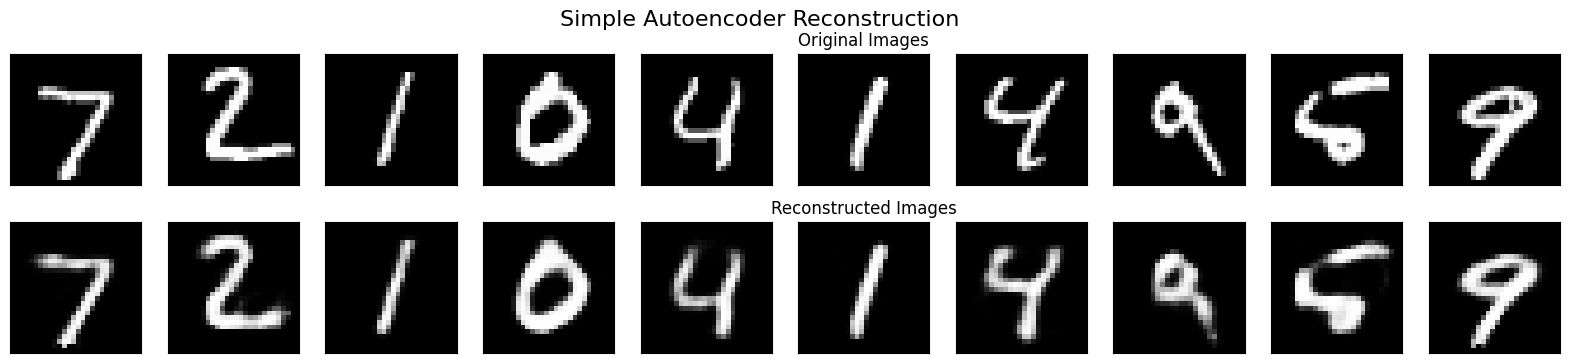

Evaluating Simple Autoencoder...
  - Average PSNR: 20.5489 dB
  - Average SSIM: 0.9184


In [14]:
visualize_reconstruction(simple_ae, test_loader, "Simple Autoencoder Reconstruction")
print("Evaluating Simple Autoencoder...")
evaluate_model_with_metrics(simple_ae, test_loader)

## **Part 2:** Denoising Autoencoder

## Helper Functions

### Add Gausian noise function

In [15]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, 0., 1.)

### Train denoising Model

In [16]:
def train_denoising_model(model, data_loader, epochs, criterion, optimizer, noise_factor=0.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in data_loader:
            images = images.to(device)
            noisy_images = add_noise(images, noise_factor)

            # Forward pass with noisy images
            reconstructed = model(noisy_images)
            # Calculate loss against ORIGINAL clean images
            loss = criterion(reconstructed, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

### Visualize denoising model

In [17]:
def visualize_denoising(model, data_loader, noise_factor=0.5, num_images=10):
    model.eval()
    with torch.no_grad():
        original_images, _ = next(iter(data_loader))
        original_images = original_images.to(device)
        noisy_images = add_noise(original_images, noise_factor)
        denoised_images = model(noisy_images)

        # Move to CPU for plotting
        original, noisy, denoised = original_images.cpu(), noisy_images.cpu(), denoised_images.cpu()

        plt.figure(figsize=(20, 6))
        plt.suptitle("Denoising Autoencoder Results", fontsize=16)
        for i in range(num_images):
            # Noisy Input
            ax = plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy[i].squeeze(), cmap='gray')
            if i == 0: ax.set_ylabel("Noisy")
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_ticks([])

            # Denoised Output
            ax = plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(denoised[i].squeeze(), cmap='gray')
            if i == 0: ax.set_ylabel("Denoised")
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_ticks([])

            # Original Image
            ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(original[i].squeeze(), cmap='gray')
            if i == 0: ax.set_ylabel("Original")
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_ticks([])
        plt.show()

### Model initialization and training

In [18]:
denoising_ae = Autoencoder(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(denoising_ae.parameters(), lr=LEARNING_RATE)

train_denoising_model(denoising_ae, train_loader, EPOCHS, criterion, optimizer)

Epoch [1/20], Loss: 0.0679
Epoch [2/20], Loss: 0.0434
Epoch [3/20], Loss: 0.0343
Epoch [4/20], Loss: 0.0308
Epoch [5/20], Loss: 0.0289
Epoch [6/20], Loss: 0.0274
Epoch [7/20], Loss: 0.0259
Epoch [8/20], Loss: 0.0248
Epoch [9/20], Loss: 0.0239
Epoch [10/20], Loss: 0.0231
Epoch [11/20], Loss: 0.0225
Epoch [12/20], Loss: 0.0220
Epoch [13/20], Loss: 0.0215
Epoch [14/20], Loss: 0.0212
Epoch [15/20], Loss: 0.0209
Epoch [16/20], Loss: 0.0206
Epoch [17/20], Loss: 0.0203
Epoch [18/20], Loss: 0.0200
Epoch [19/20], Loss: 0.0197
Epoch [20/20], Loss: 0.0195


### Visualization and Evaluation

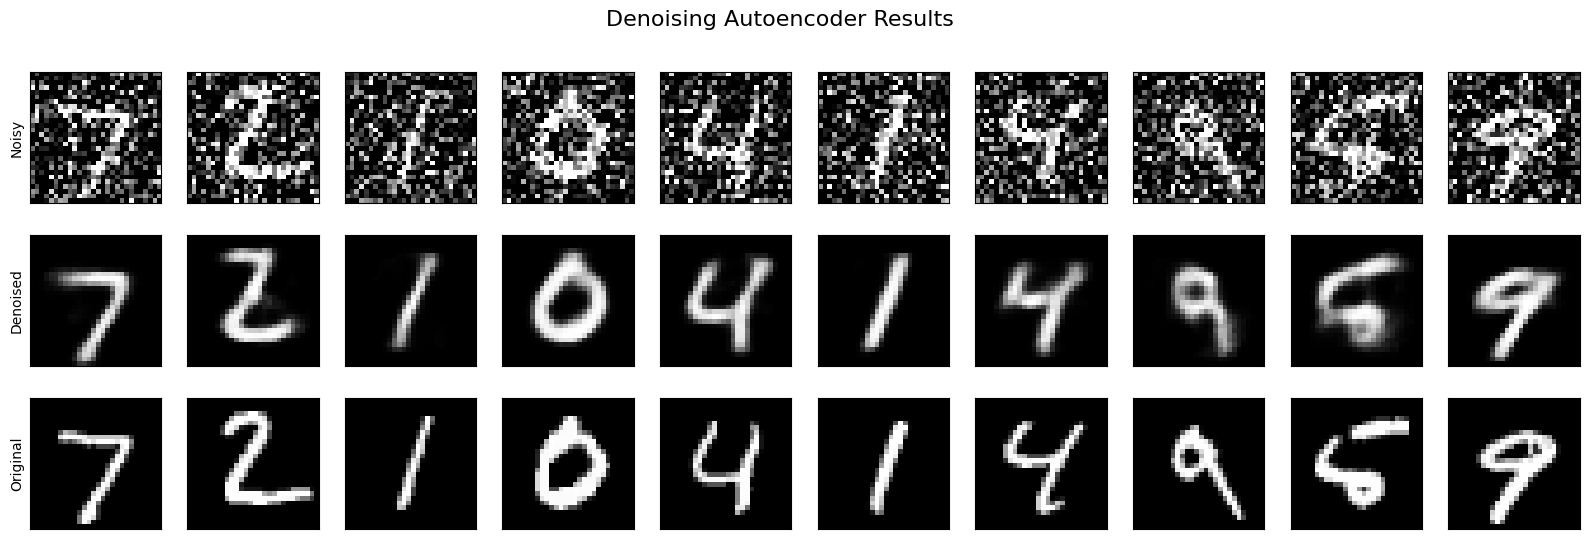

Evaluating Denoising Autoencoder (on clean images)...
  - Average PSNR: 17.4934 dB
  - Average SSIM: 0.8353


In [19]:
visualize_denoising(denoising_ae, test_loader)
print("Evaluating Denoising Autoencoder (on clean images)...")
evaluate_model_with_metrics(denoising_ae, test_loader)

## Convolutional Autoencoder

In [20]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder: (B, 1, 28, 28) -> (B, 32, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (B, 32, 7, 7)
            nn.ReLU()
        )
        # Decoder: (B, 32, 7, 7) -> (B, 1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Initialization and Training

In [21]:
# --- Initialization and Training ---
conv_ae = ConvAutoencoder().to(device)
optimizer = optim.Adam(conv_ae.parameters(), lr=LEARNING_RATE)
# We can reuse the same generic training loop!
train_model(conv_ae, train_loader, EPOCHS, criterion, optimizer)

Epoch [1/20], Loss: 0.0316
Epoch [2/20], Loss: 0.0017
Epoch [3/20], Loss: 0.0011
Epoch [4/20], Loss: 0.0009
Epoch [5/20], Loss: 0.0008
Epoch [6/20], Loss: 0.0007
Epoch [7/20], Loss: 0.0006
Epoch [8/20], Loss: 0.0006
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0005
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


### Visualization and Evaluation

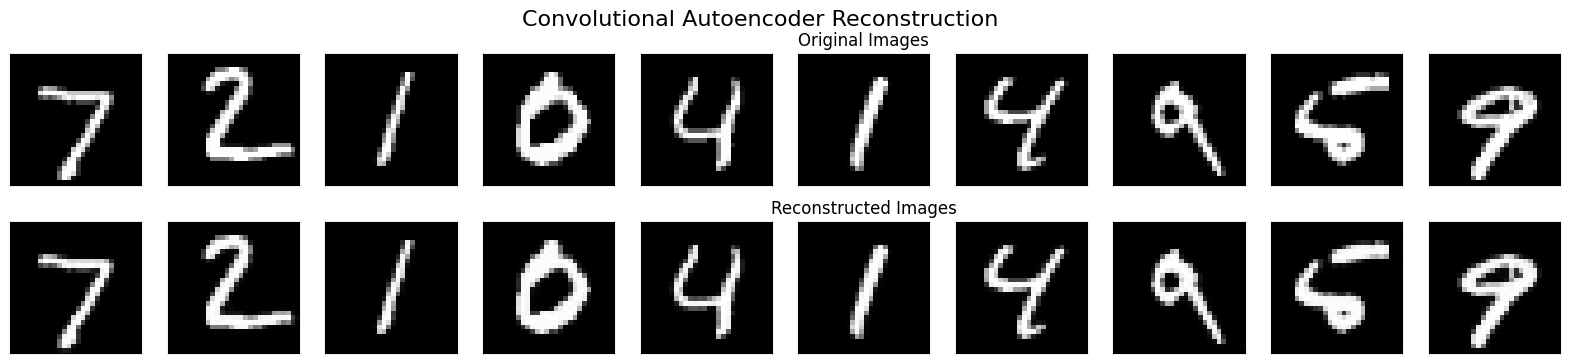

Evaluating Convolutional Autoencoder...
  - Average PSNR: 34.9625 dB
  - Average SSIM: 0.9973


In [22]:
visualize_reconstruction(conv_ae, test_loader, "Convolutional Autoencoder Reconstruction")
print("Evaluating Convolutional Autoencoder...")
evaluate_model_with_metrics(conv_ae, test_loader)

## Assignment
1. Implement the Variational Autoencoder
2. Implement a method or function to  visualize the latent space of an Autoencoder
3. Read the docs [https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html] on how to create your custom datasets

## Resources

GANs
- https://poloclub.github.io/ganlab/   

CycleGANs
- https://junyanz.github.io/CycleGAN/  

Pix2Pix GANs
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix  

ESTGANs  
- https://esrgan.readthedocs.io/en/latest/
